In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

In [161]:
DATA_PATH = './data/'

train = pd.read_csv(DATA_PATH + 'movies_train.csv')
test = pd.read_csv(DATA_PATH + 'movies_test.csv')
submission = pd.read_csv(DATA_PATH + 'submission.csv')

In [162]:
train.sample(1)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091


In [163]:
test.sample(1)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
106,댄싱퀸,CJ 엔터테인먼트,코미디,2012-01-18,124,12세 관람가,이석훈,736729.5,2,305,2


In [164]:
submission.sample(1)

,title,box_off_num
56,종로의 기적,0


In [165]:
test.nunique()

title             243
distributor        93
genre              12
release_time      182
time               70
screening_rat       4
director          220
dir_prev_bfnum    103
dir_prev_num        7
num_staff         165
num_actor          14
dtype: int64

In [166]:
submission.nunique()

title          243
box_off_num      1
dtype: int64

In [167]:
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [168]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

# dir_prev_bfnum -> 결측치 처리
1. 평균, 중앙값
## 결측치가 발생하는 경우의 수
1. 그 영화가 감독의 첫 영화인 경우?
2. 그 직전 영화의 관객 수가 알려져 있지 않은 경우 -> 알려져 있지 않은 영화들끼리 공통점이 있나?

<AxesSubplot:>

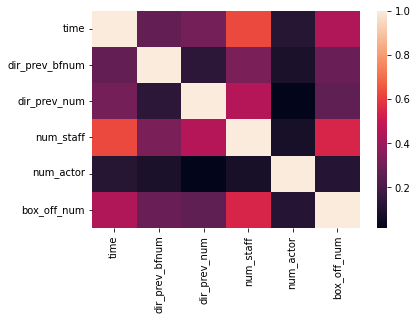

In [169]:
correl = train.corr()
sns.heatmap(data=correl)

In [170]:
tmp = train.copy()
tmp['dir_prev_bfnum'] = train['dir_prev_bfnum'].fillna('')
tmp['dir_prev_bfnum'] = train['dir_prev_bfnum'].apply(str)

eda = tmp.groupby('director')['dir_prev_bfnum'].apply(lambda x:','.join(x)).to_frame()

In [171]:
eda

,dir_prev_bfnum
director,
New Pistol,nan
강석필,nan
강성옥,nan
강우석,"nan,844821.0"
강의석,nan
...,...
황석호,nan
황욱,nan
황유식,506419.0


In [172]:
train['dir_prev_bfnum'].fillna(0, inplace = True)

In [173]:
l = np.random.rand(6)
print(l)
print(list(filter(lambda x: x > 0.7, l)))

[0.63468565 0.816868   0.5722534  0.82244214 0.53180789 0.35207363]
[0.8168680006408082, 0.8224421369018015]


#### lgbm 파라미터
- max_depth:
    - 모델의 과적합이 된 것 같다고 생각하면 줄인다
- min_data_in_leaf
    - leaf가 가지고 있는 최소한의 레코드 수
        - 레코드:
    - 모델의 과적합 시 튜닝
- feature_fraction:
    - Tree를 만들 때 매번 각각의 iteration 반복에서 파라미터 중에서 80%를 랜덤하게 선택
- bagging_fraction:
    - 매번 iteration을 돌 때 사용되는 데이터의 일부를 선택하는데 트레이닝 속도를 높이고 과적합을 방지
- lambda:
    -  regularization 정규화
- min_gain_to_split:
    - 분기하기 위해 필요한 최소한의 gain
    - Tree에서 유용한 분기의 수를 컨트롤
- max_cat_group:
    - 카테고리 수가 클 때, 과적합을 방지하는 분기 포인트

In [174]:
lgbm_model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [175]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [176]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [177]:
X_train.sample(1)

,time,dir_prev_num,num_staff,num_actor
101,139,2,298,6


In [178]:
lgbm_model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [179]:
singleLGBM_result = submission.copy()

In [180]:
singleLGBM_result.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [181]:
singleLGBM_result['box_off_num'] = lgbm_model.predict(X_test)

In [182]:
singleLGBM_result.head()

,title,box_off_num
0,용서는 없다,2.817995e+06
1,아빠가 여자를 좋아해,3.753772e+05
2,하모니,-5.693243e+05
3,의형제,1.581189e+06
4,평행 이론,-5.277806e+05


In [183]:
from sklearn.model_selection import KFold

In [184]:
kfold = KFold(n_splits=5, shuffle=True, random_state=777)

In [185]:
for train_idx, val_idx in kfold.split(X_train):
    print(len(train_idx), len(val_idx))
    break
print(len(X_train))
print(len(X_test))
print(len(train))
print(len(test))

480 120
600
243
600
243


In [186]:
kfold_lgbm_model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [187]:
X_train.iloc[train_idx]

,time,dir_prev_num,num_staff,num_actor
0,96,0,91,2
1,130,2,387,3
2,123,4,343,4
3,101,2,20,6
4,108,1,251,2
...,...,...,...,...
595,111,1,510,7
596,127,1,286,6
597,99,0,123,4
598,102,0,431,4


In [188]:
lgbm_models = []
# kfold를 split해서
for train_idx, val_idx in kfold.split(X_train):
    train_data = X_train.iloc[train_idx]
    train_target = y_train.iloc[train_idx]
    valid_data = X_train.iloc[val_idx]
    valid_target = y_train.iloc[val_idx]
    
    lgbm_models.append(kfold_lgbm_model.fit(train_data, train_target, \
        eval_set=(valid_data, valid_target), early_stopping_rounds=100, verbose=100))

c:\Users\kjsjh\anaconda3\envs\pytorch\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\kjsjh\anaconda3\envs\pytorch\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.70572e+12
[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


In [189]:
lgbm_models[0]

LGBMRegressor(n_estimators=1000, random_state=777)

In [190]:
preds = []
for model in lgbm_models:
    preds.append(model.predict(X_test))
len(preds)

5

In [191]:
kfoldLightGBM = submission.copy()

In [192]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis=0)

In [193]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


In [199]:
kfoldLightGBM['box_off_num'] = kfoldLightGBM['box_off_num'].apply(int)
# kfoldLightGBM.index = kfoldLightGBM['title']

In [203]:
kfoldLightGBM = kfoldLightGBM.drop('title', axis=1)

In [158]:
# kfoldLightGBM.drop(kfoldLightGBM['title'], inplace=True)

In [197]:
# kfoldLightGBM.reset_index()

ValueError: cannot insert title, already exists

In [204]:
kfoldLightGBM.sample(1)

,box_off_num
title,
타이밍,64707


In [205]:
kfoldLightGBM.to_csv('lgbm_5fold_result.csv')